In [1]:
!pip install tensorflow_datasets

In [3]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

In [4]:
def map_image(image, label):
  '''Normalizes and flattens the image. Returns image as input and label.'''
  image = tf.cast(image, dtype=tf.float32)
  image = image / 255.0
  image = tf.reshape(image, shape=(28,28,1))# change dimension

  return image, image

In [7]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split="test")
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

In [8]:
def cnn_encoder(inputs):
    conv_1 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    max_pool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_1)  # Downsample to (14, 14)
    
    conv_2 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(max_pool_1)
    max_pool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv_2)  # Downsample to (7, 7)
    
    return max_pool_2


def bottle_neck(inputs):
    bottle_neck_layer = tf.keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    encoder_visualization = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation="sigmoid", padding="same")(bottle_neck_layer)
    return bottle_neck_layer, encoder_visualization


def decoder(inputs):
    conv_1 = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation="relu", padding="same")(inputs)
    up_sample_1 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_1)  # Upsample to (14, 14)
    
    conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", padding="same")(up_sample_1)
    up_sample_2 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv_2)  # Upsample to (28, 28)
    
    conv_3 = tf.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), activation="sigmoid", padding="same")(up_sample_2)
    return conv_3

def cnn_autoencoder():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))  # Input shape for grayscale image
    encoder_output = cnn_encoder(inputs)
    bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
    decoder_output = decoder(bottleneck_output)
    cnn_model = tf.keras.Model(inputs=inputs, outputs=decoder_output)
    encoder_model = tf.keras.Model(inputs=inputs, outputs=encoder_visualization)
    return cnn_model, encoder_model

cnn_model, encoder_model = cnn_autoencoder()
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 7, 7, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 7, 7, 128)           │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_2 (UpSampling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 14, 14, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ up_sampling2d_3 (UpSampling2D)       │ (None, 28, 28, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 28, 28, 1)           │             577 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 739,073 (2.82 MB)

 Trainable params: 739,073 (2.82 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
step=60000//BATCH_SIZE
his=cnn_model.fit(train_dataset,steps_per_epoch=step,epochs=7)

Epoch 1/7
468/468 ━━━━━━━━━━━━━━━━━━━━ 155s 319ms/step - accuracy: 0.5039 - loss: 0.3230
Epoch 2/7
468/468 ━━━━━━━━━━━━━━━━━━━━ 157s 335ms/step - accuracy: 0.5100 - loss: 0.2617
Epoch 3/7
468/468 ━━━━━━━━━━━━━━━━━━━━ 151s 322ms/step - accuracy: 0.5105 - loss: 0.2554
Epoch 4/7
468/468 ━━━━━━━━━━━━━━━━━━━━ 148s 317ms/step - accuracy: 0.5103 - loss: 0.2527
Epoch 5/7
468/468 ━━━━━━━━━━━━━━━━━━━━ 179s 382ms/step - accuracy: 0.5102 - loss: 0.2511
Epoch 6/7
468/468 ━━━━━━━━━━━━━━━━━━━━ 210s 450ms/step - accuracy: 0.5106 - loss: 0.2499
Epoch 7/7
468/468 ━━━━━━━━━━━━━━━━━━━━ 240s 512ms/step - accuracy: 0.5105 - loss: 0.2490


Text(0, 0.5, 'Loss')

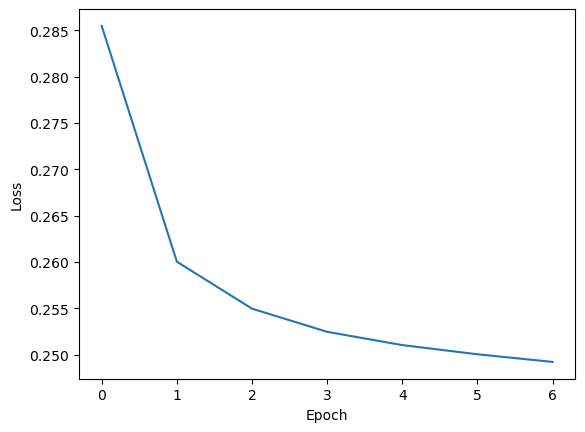

In [11]:
plt.plot(his.history["loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [13]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,1))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


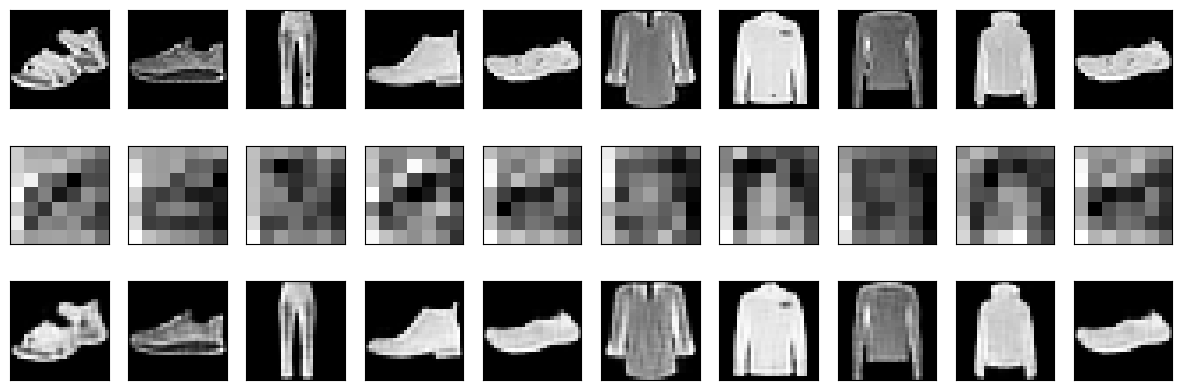

In [14]:

test_dataset = test_dataset.take(1)
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

idxs = np.random.choice(BATCH_SIZE, size=10)
encoded_predicted = encoder_model.predict(test_dataset)

# get a prediction for the test batch
simple_predicted = cnn_model.predict(test_dataset)

# display the 10 samples, encodings and decoded values!
display_results(output_samples[idxs], encoded_predicted[idxs], simple_predicted[idxs],enc_shape=(7,7)) #added enc_shape